#### 1. Import relevant modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from tqdm import tqdm

#### 2. Load data

In [2]:
def load_data(batch_size, transform):
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                                download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                            shuffle=False)
    return train_loader, test_loader

#### 3. Create concolution and linear blocks

In [3]:
def CnnBlock(channels_inputs, activation, bias):
    block = []
    for i in range(len(channels_inputs) - 1):
        block.append(nn.Conv2d(in_channels=channels_inputs[i], 
                                out_channels=channels_inputs[i + 1], 
                               kernel_size=3, bias=bias))
        # block.append(nn.BatchNorm2d(num_features=channels_inputs[i + 1]))
        block.append(activation)
        block.append(nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1)))
    block.append(nn.Flatten(start_dim=1, end_dim=-1))
    return nn.Sequential(*block)

def LinearBlock(linear_inputs, activation, bias):
    block = []
    for i in range(len(linear_inputs) - 2):
        block.append(nn.Linear(in_features=linear_inputs[i], out_features=linear_inputs[i + 1], bias=bias))
        block.append(activation)
    block.append(nn.Linear(linear_inputs[-2], linear_inputs[-1], bias=bias))
    return nn.Sequential(*block)

#### 4. Create cnn model with single CnnBlock and signle LinearBlock

In [4]:
class MyConvNet(nn.Module):
    def __init__(self, input_image, out_classes, convs, lins, activation=nn.ReLU(), bias=True, lr=0.01):
        super(MyConvNet, self).__init__()
        input_channel = input_image[0] if len(input_image) >= 2 else 1
        input_channels = [input_channel] + convs
        self.cnn_part = CnnBlock(input_channels, activation, bias=bias)
        input_linear = self.cnn_part(torch.rand(input_image)[None, :]).size(-1)
        inputs_linear = [input_linear] + lins + [out_classes]
        self.linear_part = LinearBlock(inputs_linear, activation, bias=bias)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        x = self.cnn_part(x)
        x = self.linear_part(x)
        return x

#### 5. Extract the input and output dimention from train loader

In [5]:
def get_dims(train_loader):
    in_image = torch.tensor(train_loader.dataset.data.shape)[[-1, 2, 1]]
    classes = ['plane', 'car'] + train_loader.dataset.classes[2:]
    return tuple(in_image.numpy()), classes

#### 6. fit end evaluate our model

In [14]:
def fit(model, train_loader, num_epochs, idx, device='cpu'):
    print(f'\nStart train model {idx + 1}\n')
    model.train()
    n_batches = len(train_loader)
    step_spaces = np.ceil(np.log10(n_batches + 1)).astype(int)
    epoch_spaces = np.ceil(np.log10(num_epochs + 1)).astype(int)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = model.criterion(outputs, labels)

            model.optimizer.zero_grad()
            loss.backward()
            model.optimizer.step()

            if (i+1) % (n_batches // 10) == 0:
                print (f'model {idx + 1}, Epoch [{str(epoch + 1).rjust(epoch_spaces)}/{num_epochs}], Step [{str(i + 1).rjust(step_spaces)}/{n_batches}], Loss: {loss.item():.4f}')
    print(f'\nFinish train model {idx + 1}\n')

def evaluate(model, test_loader, classes, idx, plot=True, device='cpu'):
    model.eval()
    y_true = torch.Tensor([]).to(device)
    y_pred = torch.Tensor([]).to(device)
    with torch.no_grad():
        n_correct, n_samples = 0, 0
        for images, labels in tqdm(test_loader, desc=f'test model {idx + 1} '):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            y_true = torch.cat((y_true, labels), dim=0)
            y_pred = torch.cat((y_pred, predicted), dim=0)

    acc = 100.0 * n_correct / n_samples
    print(f'\nAccuracy of model {idx + 1}: {acc} %')
    if plot:
        plot_results(y_true.cpu().numpy(), y_pred.cpu().numpy(), classes, fig_size=(24, 12))
    return acc


def train_test_model(model, train_loader, test_loader, classes, num_epochs):
    fit(model, train_loader, num_epochs=num_epochs, idx=0)
    test_acc = evaluate(model, test_loader, classes, idx=0)
    return test_acc

#### 7. Plot results

In [7]:
def plot_results(y_true, y_pred, classes, fig_size=(24, 12)):
    f_beta = []
    conf_matrix = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    acc = 100.0 * accuracy_score(y_true, y_pred)
    fig, ax = plt.subplots(figsize=fig_size)

    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    group_percentages = ["{0:.1%}".format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]
    labels = np.asarray([f'{v1}\n\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]).reshape(len(classes), len(classes))
    sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 16}, ax=ax)
    ax.set_title(f'Confusion Matrix for fnn Classifier (accuracy = {acc:.2f} %)\n', fontsize=16);
    ax.set_xlabel('\nPredicted Values\n', fontsize=20)
    ax.set_ylabel('Actual Values\n', fontsize=20);
    ax.xaxis.set_ticklabels(classes, fontsize=14)
    ax.yaxis.set_ticklabels(classes, fontsize=14)
    ax.tick_params(axis='both', labelsize=20)
    plt.show()
    print('\n')
    fig, ax = plt.subplots(figsize=fig_size)
    t_samples = conf_matrix.sum(axis=1)
    vals_acc = []
    for i in range(len(classes)):
        val = 100.0 * conf_matrix[i, i] / t_samples[i] if t_samples[i] else 0
        vals_acc.append(val)
        x_text = i - 0.02 - 0.1 * (1 + int(val>=10))
        plt.text(x_text, val + 0.1, f'{val:.1f}', fontsize=20)
    plt.bar(classes, vals_acc, width=0.8)
    plt.title('Accuracy of each classs', fontsize=20)
    plt.xlabel('Class', fontsize=20)
    plt.ylabel('Accuracy [%]', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylim(top=110) 
    plt.grid()
    plt.show()

#### 8. Create grid serch for training different models

In [16]:
def grid_search(grid, input_size, classes, train_loader, test_loader, num_epochs, device='cpu'):
    models = []
    models_grid = []
    output_size = len(classes)
    for i, data in enumerate(itertools.product(*list(grid.values()))):
        convs,  lins, activation, bias, lr = data
        model = MyConvNet(input_size, output_size, convs=convs, lins=lins, activation=activation, bias=bias).to(device)
        models.append(model)
        models_grid.append({'convs': convs, 'lins': lins, 'activation': activation, 'bias': bias, 'lr': lr})

    print(f'\nNumber of models to traion : {len(models)}\n')
    test_acc_lst = []
    for k, model in enumerate(models):
        fit(model, train_loader, num_epochs=num_epochs, idx=k, device=device)
        acc = evaluate(model, test_loader, classes, idx=k, device=device)
        test_acc_lst.append(acc)


    max_acc_idx = np.argmax(test_acc_lst)
    print(f'\nFinished Training models\n')
    print(f'best model : model {max_acc_idx + 1} with accuracy : {test_acc_lst[max_acc_idx]} % \n')
    print(f'best model grid : {models_grid[max_acc_idx]}')
    print(f'best model architecture : \n {models[max_acc_idx]}')
    return models[max_acc_idx]


#### 9. Run the code

Files already downloaded and verified
Files already downloaded and verified
Number of models to traion : 8

Start train model 1

model 1, Epoch [ 1/10], Step [ 156/1563], Loss: 2.2406
model 1, Epoch [ 1/10], Step [ 312/1563], Loss: 1.8031
model 1, Epoch [ 1/10], Step [ 468/1563], Loss: 1.7197
model 1, Epoch [ 1/10], Step [ 624/1563], Loss: 1.8392
model 1, Epoch [ 1/10], Step [ 780/1563], Loss: 1.9945
model 1, Epoch [ 1/10], Step [ 936/1563], Loss: 1.8756
model 1, Epoch [ 1/10], Step [1092/1563], Loss: 1.9848
model 1, Epoch [ 1/10], Step [1248/1563], Loss: 1.7106
model 1, Epoch [ 1/10], Step [1404/1563], Loss: 2.2951
model 1, Epoch [ 1/10], Step [1560/1563], Loss: 1.6500
model 1, Epoch [ 2/10], Step [ 156/1563], Loss: 1.7004
model 1, Epoch [ 2/10], Step [ 312/1563], Loss: 1.5209
model 1, Epoch [ 2/10], Step [ 468/1563], Loss: 1.5417
model 1, Epoch [ 2/10], Step [ 624/1563], Loss: 1.9353
model 1, Epoch [ 2/10], Step [ 780/1563], Loss: 1.7995
model 1, Epoch [ 2/10], Step [ 936/1563], Loss

test model 1 : 100%|██████████| 313/313 [00:03<00:00, 94.87it/s]



Accuracy of model 1: 40.83 %


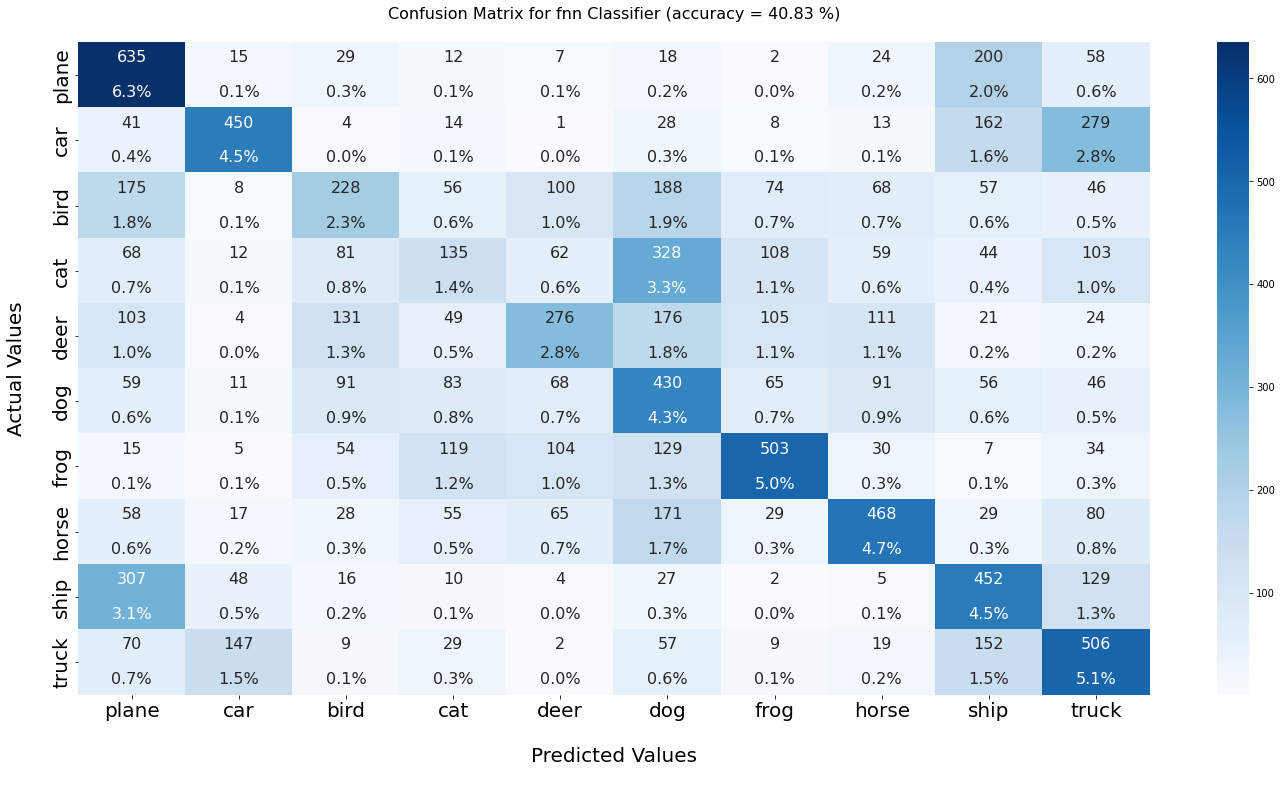

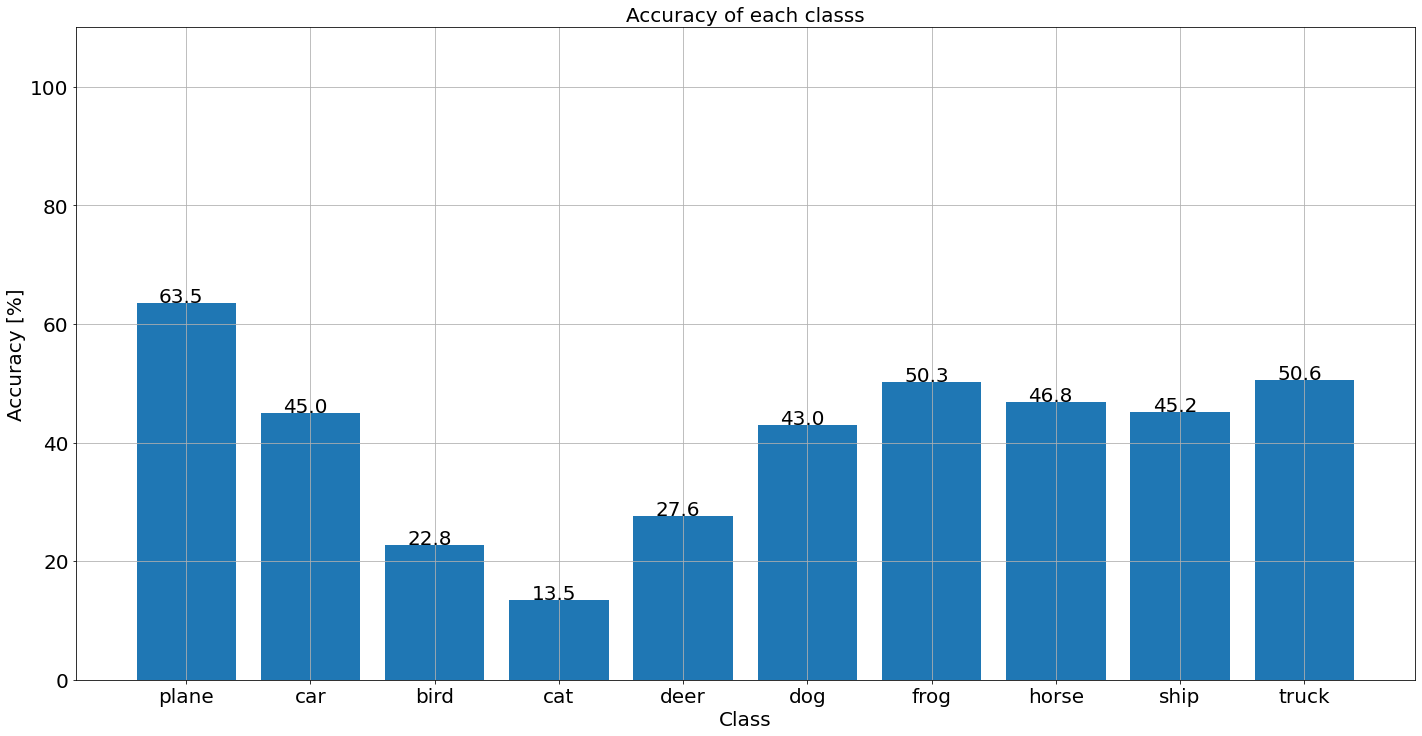


Start train model 2

model 2, Epoch [ 1/10], Step [ 156/1563], Loss: 2.3070
model 2, Epoch [ 1/10], Step [ 312/1563], Loss: 2.3104
model 2, Epoch [ 1/10], Step [ 468/1563], Loss: 2.3072
model 2, Epoch [ 1/10], Step [ 624/1563], Loss: 2.2982
model 2, Epoch [ 1/10], Step [ 780/1563], Loss: 2.3063
model 2, Epoch [ 1/10], Step [ 936/1563], Loss: 2.3020
model 2, Epoch [ 1/10], Step [1092/1563], Loss: 2.3007
model 2, Epoch [ 1/10], Step [1248/1563], Loss: 2.2978
model 2, Epoch [ 1/10], Step [1404/1563], Loss: 2.3081
model 2, Epoch [ 1/10], Step [1560/1563], Loss: 2.2892
model 2, Epoch [ 2/10], Step [ 156/1563], Loss: 2.3030
model 2, Epoch [ 2/10], Step [ 312/1563], Loss: 2.3039
model 2, Epoch [ 2/10], Step [ 468/1563], Loss: 2.3024
model 2, Epoch [ 2/10], Step [ 624/1563], Loss: 2.3081
model 2, Epoch [ 2/10], Step [ 780/1563], Loss: 2.2940
model 2, Epoch [ 2/10], Step [ 936/1563], Loss: 2.3042
model 2, Epoch [ 2/10], Step [1092/1563], Loss: 2.3186
model 2, Epoch [ 2/10], Step [1248/1563], L

test model 2 : 100%|██████████| 313/313 [00:03<00:00, 91.32it/s]



Accuracy of model 2: 10.0 %


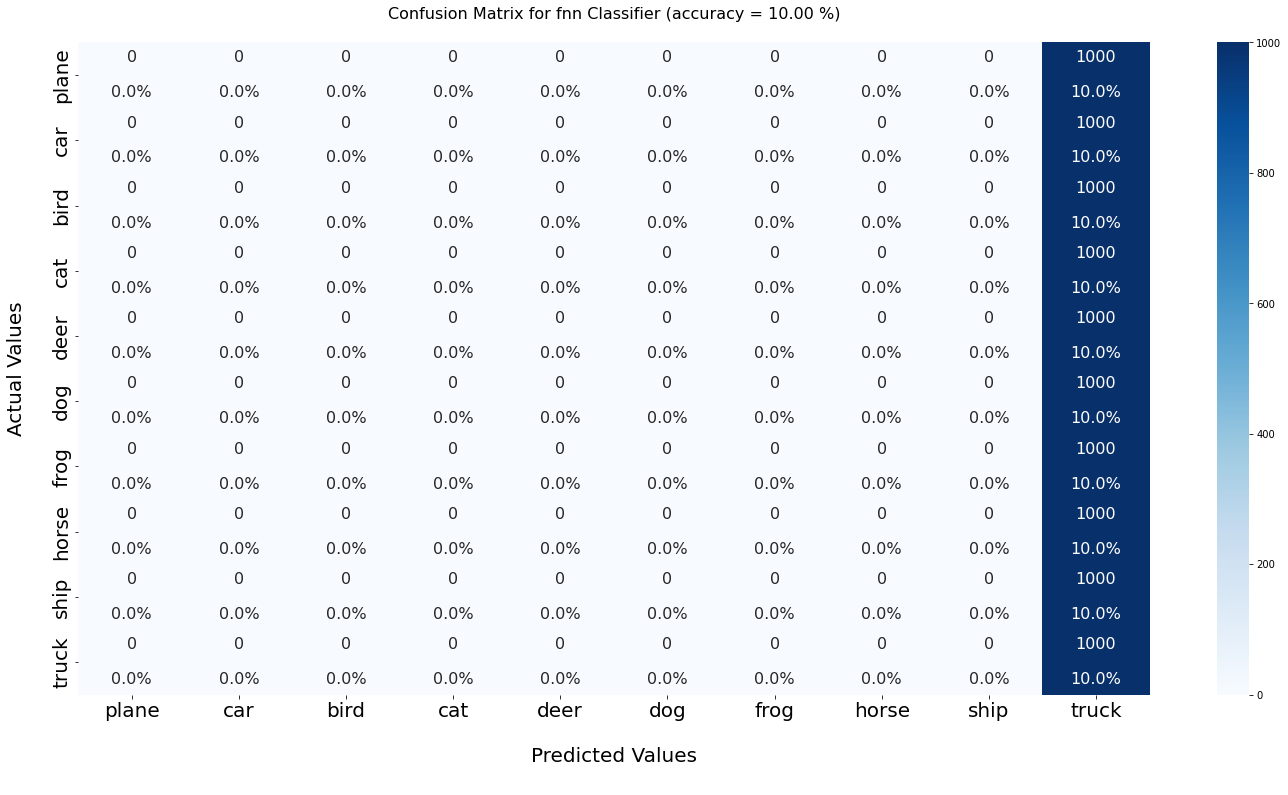

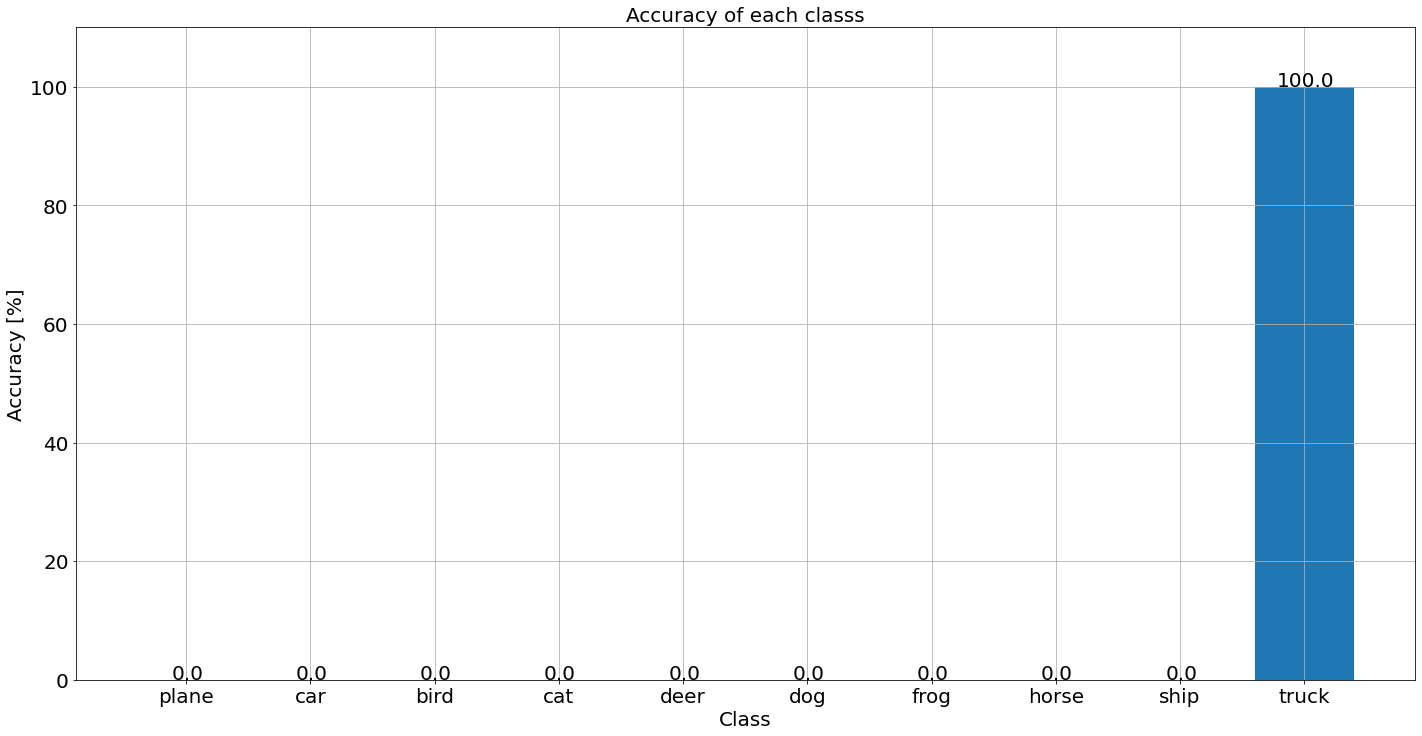


Start train model 3

model 3, Epoch [ 1/10], Step [ 156/1563], Loss: 2.3001
model 3, Epoch [ 1/10], Step [ 312/1563], Loss: 2.2940
model 3, Epoch [ 1/10], Step [ 468/1563], Loss: 2.3060
model 3, Epoch [ 1/10], Step [ 624/1563], Loss: 2.2978
model 3, Epoch [ 1/10], Step [ 780/1563], Loss: 2.2994
model 3, Epoch [ 1/10], Step [ 936/1563], Loss: 2.3175
model 3, Epoch [ 1/10], Step [1092/1563], Loss: 2.2870
model 3, Epoch [ 1/10], Step [1248/1563], Loss: 2.2851
model 3, Epoch [ 1/10], Step [1404/1563], Loss: 2.3086
model 3, Epoch [ 1/10], Step [1560/1563], Loss: 2.2909
model 3, Epoch [ 2/10], Step [ 156/1563], Loss: 2.3158
model 3, Epoch [ 2/10], Step [ 312/1563], Loss: 2.3012
model 3, Epoch [ 2/10], Step [ 468/1563], Loss: 2.3084
model 3, Epoch [ 2/10], Step [ 624/1563], Loss: 2.3093
model 3, Epoch [ 2/10], Step [ 780/1563], Loss: 2.3008
model 3, Epoch [ 2/10], Step [ 936/1563], Loss: 2.3156
model 3, Epoch [ 2/10], Step [1092/1563], Loss: 2.3018
model 3, Epoch [ 2/10], Step [1248/1563], L

test model 3 : 100%|██████████| 313/313 [00:03<00:00, 94.82it/s]



Accuracy of model 3: 10.0 %


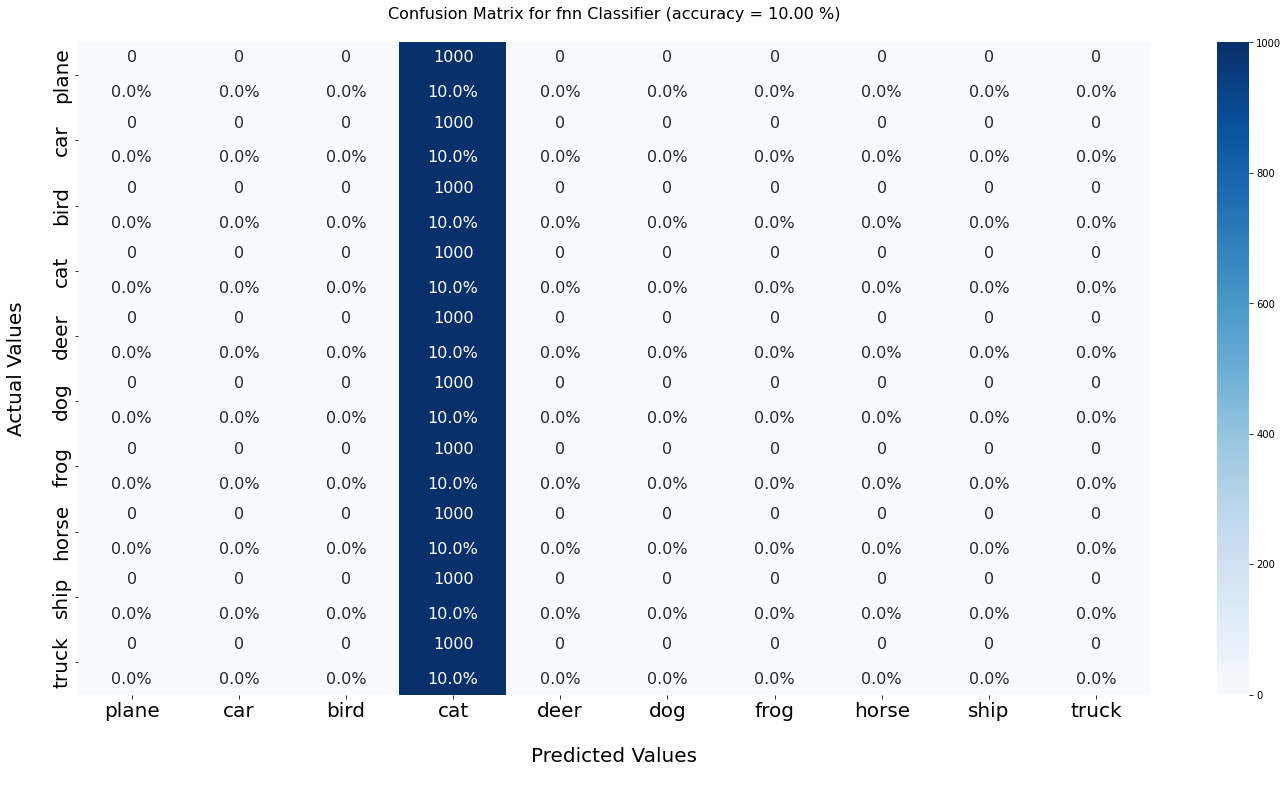

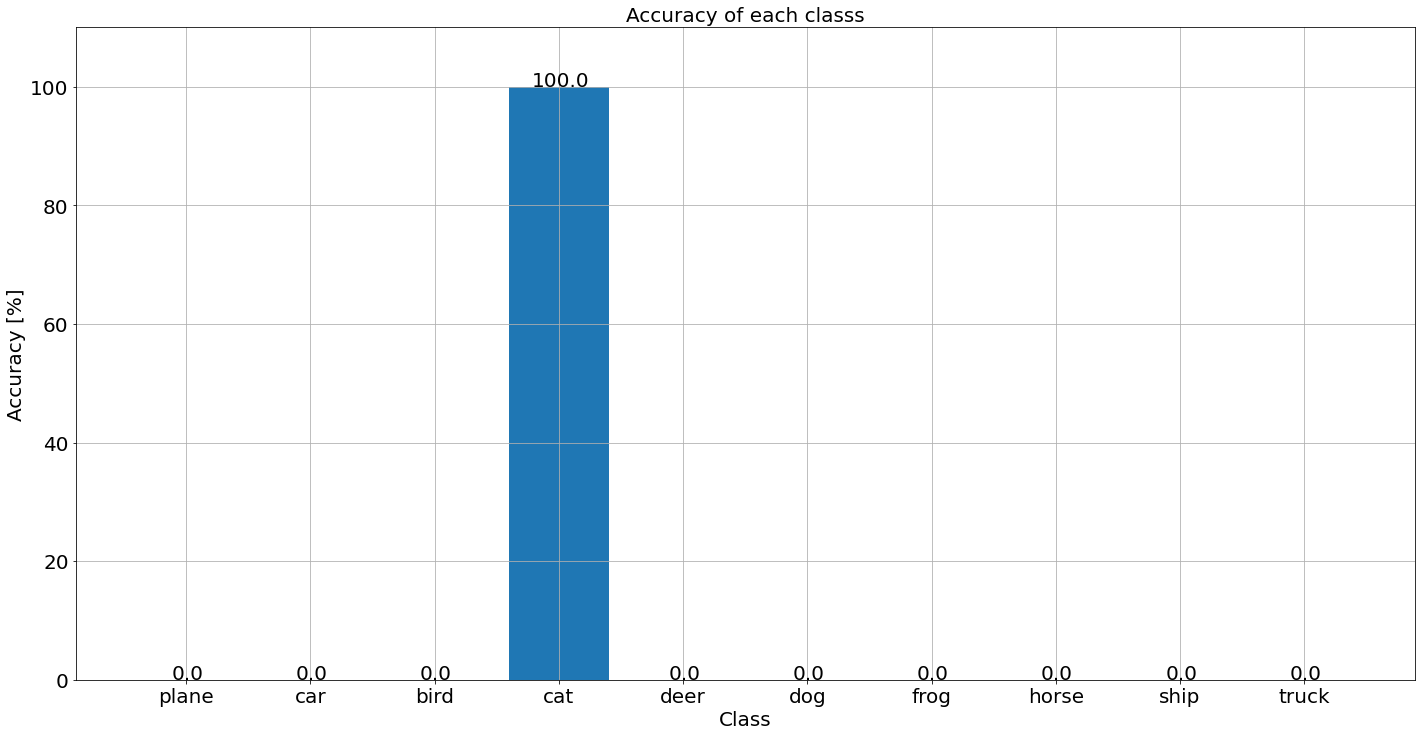


Start train model 4

model 4, Epoch [ 1/10], Step [ 156/1563], Loss: 2.2980
model 4, Epoch [ 1/10], Step [ 312/1563], Loss: 2.0959
model 4, Epoch [ 1/10], Step [ 468/1563], Loss: 2.0173
model 4, Epoch [ 1/10], Step [ 624/1563], Loss: 2.1647
model 4, Epoch [ 1/10], Step [ 780/1563], Loss: 2.1240
model 4, Epoch [ 1/10], Step [ 936/1563], Loss: 2.2977
model 4, Epoch [ 1/10], Step [1092/1563], Loss: 1.9235
model 4, Epoch [ 1/10], Step [1248/1563], Loss: 2.1459
model 4, Epoch [ 1/10], Step [1404/1563], Loss: 2.0254
model 4, Epoch [ 1/10], Step [1560/1563], Loss: 1.7037
model 4, Epoch [ 2/10], Step [ 156/1563], Loss: 2.1137
model 4, Epoch [ 2/10], Step [ 312/1563], Loss: 1.7472
model 4, Epoch [ 2/10], Step [ 468/1563], Loss: 1.6995
model 4, Epoch [ 2/10], Step [ 624/1563], Loss: 1.9504
model 4, Epoch [ 2/10], Step [ 780/1563], Loss: 2.3130
model 4, Epoch [ 2/10], Step [ 936/1563], Loss: 2.0625
model 4, Epoch [ 2/10], Step [1092/1563], Loss: 1.9385
model 4, Epoch [ 2/10], Step [1248/1563], L

test model 4 : 100%|██████████| 313/313 [00:03<00:00, 92.92it/s]



Accuracy of model 4: 36.1 %


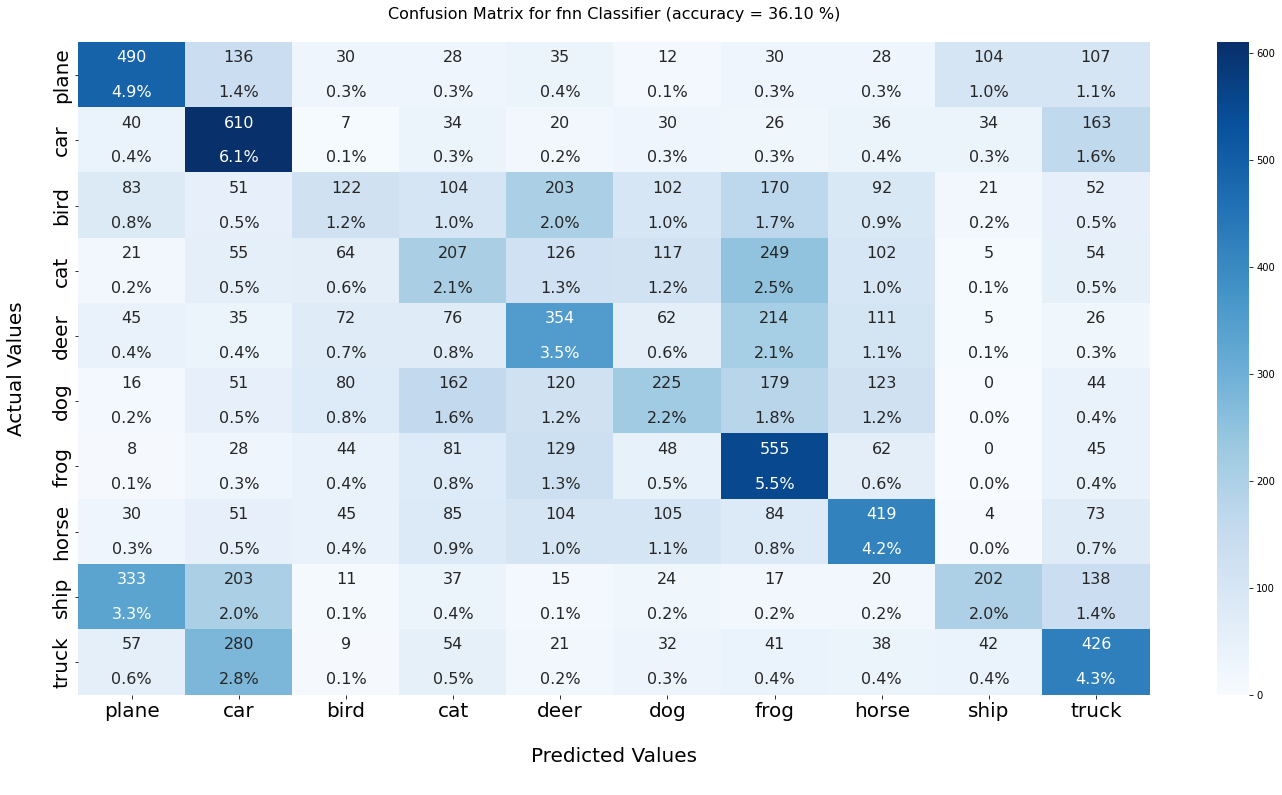

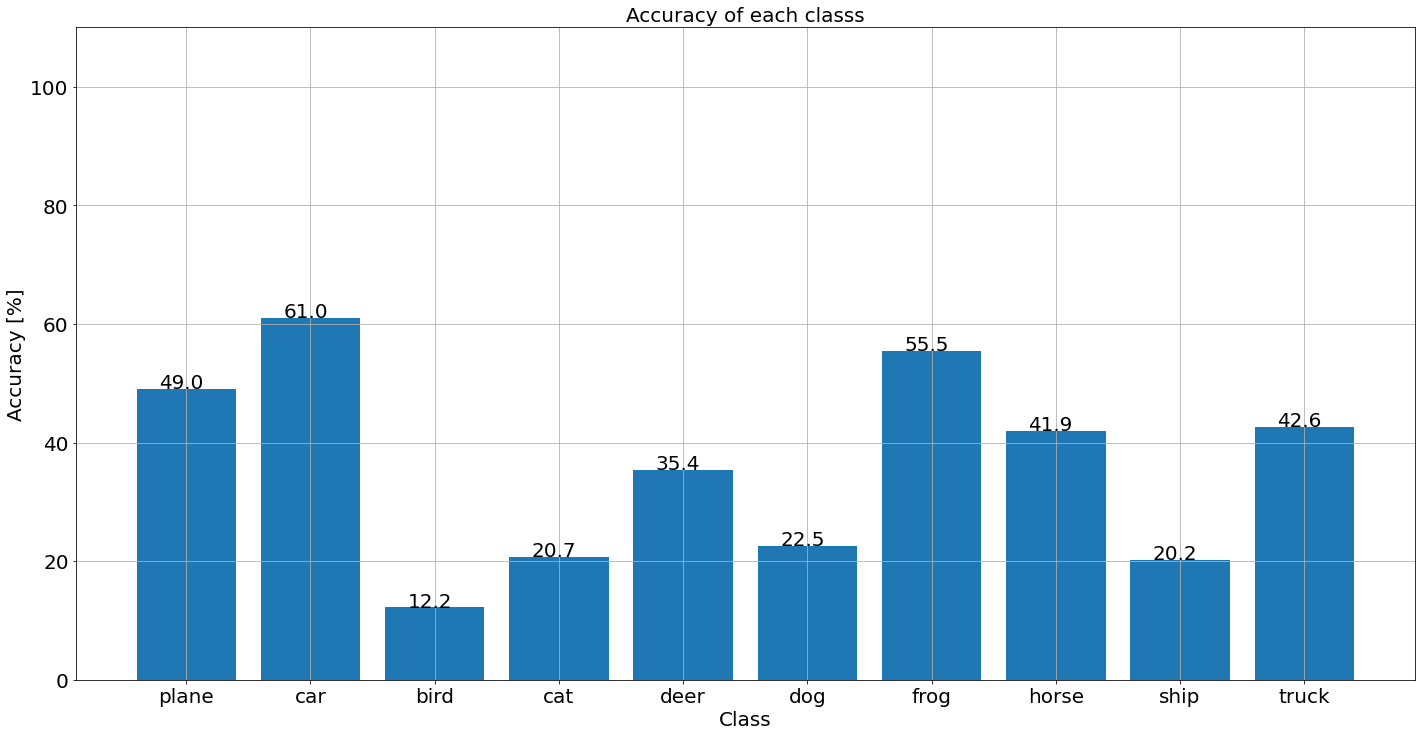


Start train model 5

model 5, Epoch [ 1/10], Step [ 156/1563], Loss: 2.3105
model 5, Epoch [ 1/10], Step [ 312/1563], Loss: 2.3075
model 5, Epoch [ 1/10], Step [ 468/1563], Loss: 2.3049
model 5, Epoch [ 1/10], Step [ 624/1563], Loss: 2.3042
model 5, Epoch [ 1/10], Step [ 780/1563], Loss: 2.3043
model 5, Epoch [ 1/10], Step [ 936/1563], Loss: 2.2905
model 5, Epoch [ 1/10], Step [1092/1563], Loss: 2.2994
model 5, Epoch [ 1/10], Step [1248/1563], Loss: 2.2992
model 5, Epoch [ 1/10], Step [1404/1563], Loss: 2.3040
model 5, Epoch [ 1/10], Step [1560/1563], Loss: 2.3139
model 5, Epoch [ 2/10], Step [ 156/1563], Loss: 2.2995
model 5, Epoch [ 2/10], Step [ 312/1563], Loss: 2.2927
model 5, Epoch [ 2/10], Step [ 468/1563], Loss: 2.3001
model 5, Epoch [ 2/10], Step [ 624/1563], Loss: 2.2914
model 5, Epoch [ 2/10], Step [ 780/1563], Loss: 2.3177
model 5, Epoch [ 2/10], Step [ 936/1563], Loss: 2.3042
model 5, Epoch [ 2/10], Step [1092/1563], Loss: 2.3014
model 5, Epoch [ 2/10], Step [1248/1563], L

test model 5 : 100%|██████████| 313/313 [00:03<00:00, 83.41it/s]



Accuracy of model 5: 10.0 %


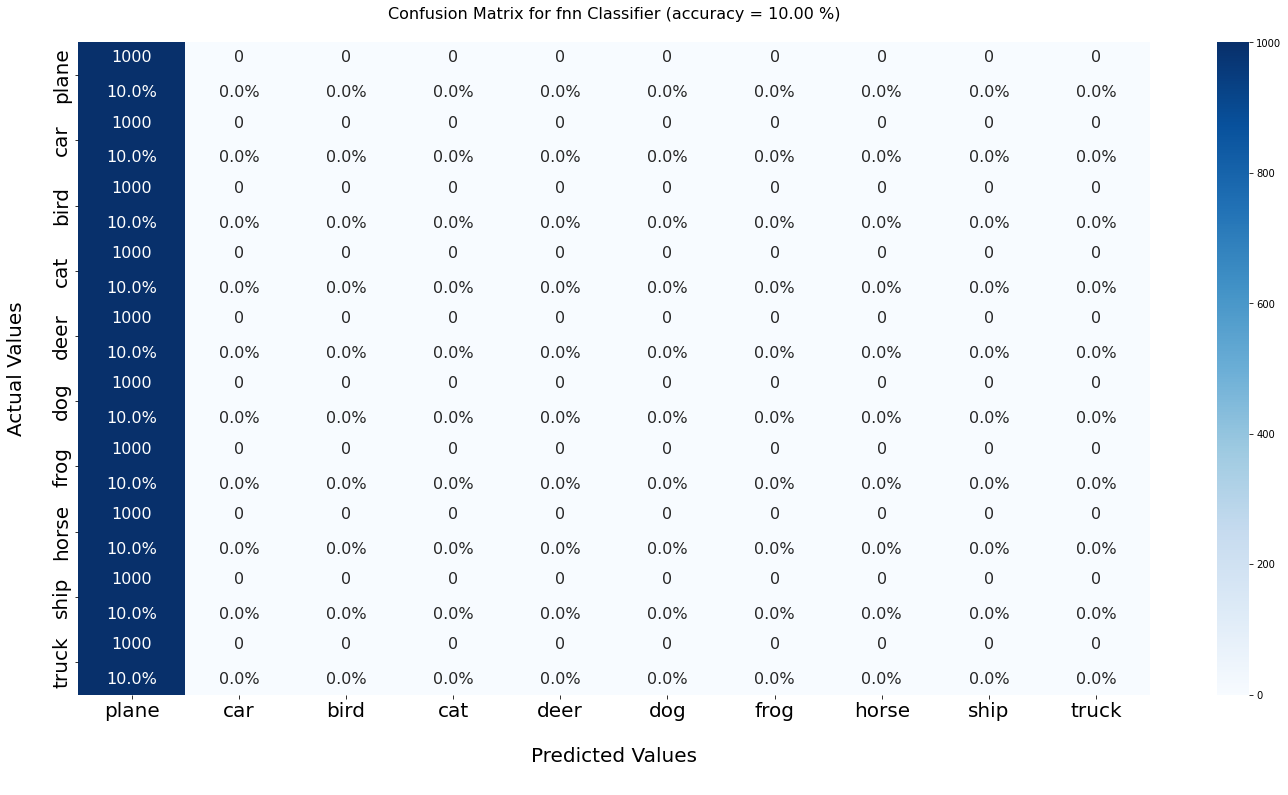

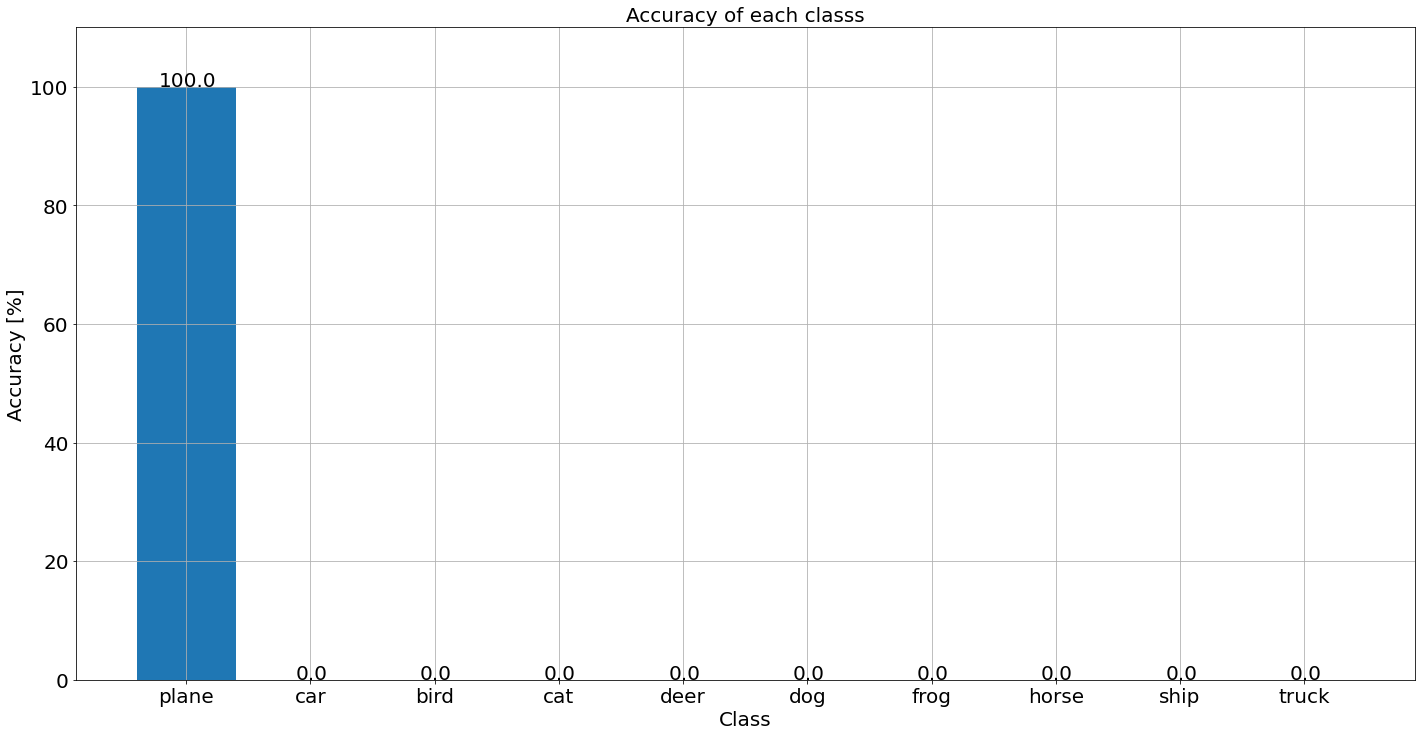


Start train model 6

model 6, Epoch [ 1/10], Step [ 156/1563], Loss: 2.0187
model 6, Epoch [ 1/10], Step [ 312/1563], Loss: 1.9827
model 6, Epoch [ 1/10], Step [ 468/1563], Loss: 1.9228
model 6, Epoch [ 1/10], Step [ 624/1563], Loss: 2.0398
model 6, Epoch [ 1/10], Step [ 780/1563], Loss: 1.7797
model 6, Epoch [ 1/10], Step [ 936/1563], Loss: 1.7660
model 6, Epoch [ 1/10], Step [1092/1563], Loss: 1.8742
model 6, Epoch [ 1/10], Step [1248/1563], Loss: 1.8759
model 6, Epoch [ 1/10], Step [1404/1563], Loss: 1.9722
model 6, Epoch [ 1/10], Step [1560/1563], Loss: 1.8703
model 6, Epoch [ 2/10], Step [ 156/1563], Loss: 2.0011
model 6, Epoch [ 2/10], Step [ 312/1563], Loss: 1.8833
model 6, Epoch [ 2/10], Step [ 468/1563], Loss: 1.8185
model 6, Epoch [ 2/10], Step [ 624/1563], Loss: 1.5032
model 6, Epoch [ 2/10], Step [ 780/1563], Loss: 1.8338
model 6, Epoch [ 2/10], Step [ 936/1563], Loss: 1.6904
model 6, Epoch [ 2/10], Step [1092/1563], Loss: 1.7407
model 6, Epoch [ 2/10], Step [1248/1563], L

test model 6 : 100%|██████████| 313/313 [00:03<00:00, 82.99it/s]



Accuracy of model 6: 26.88 %


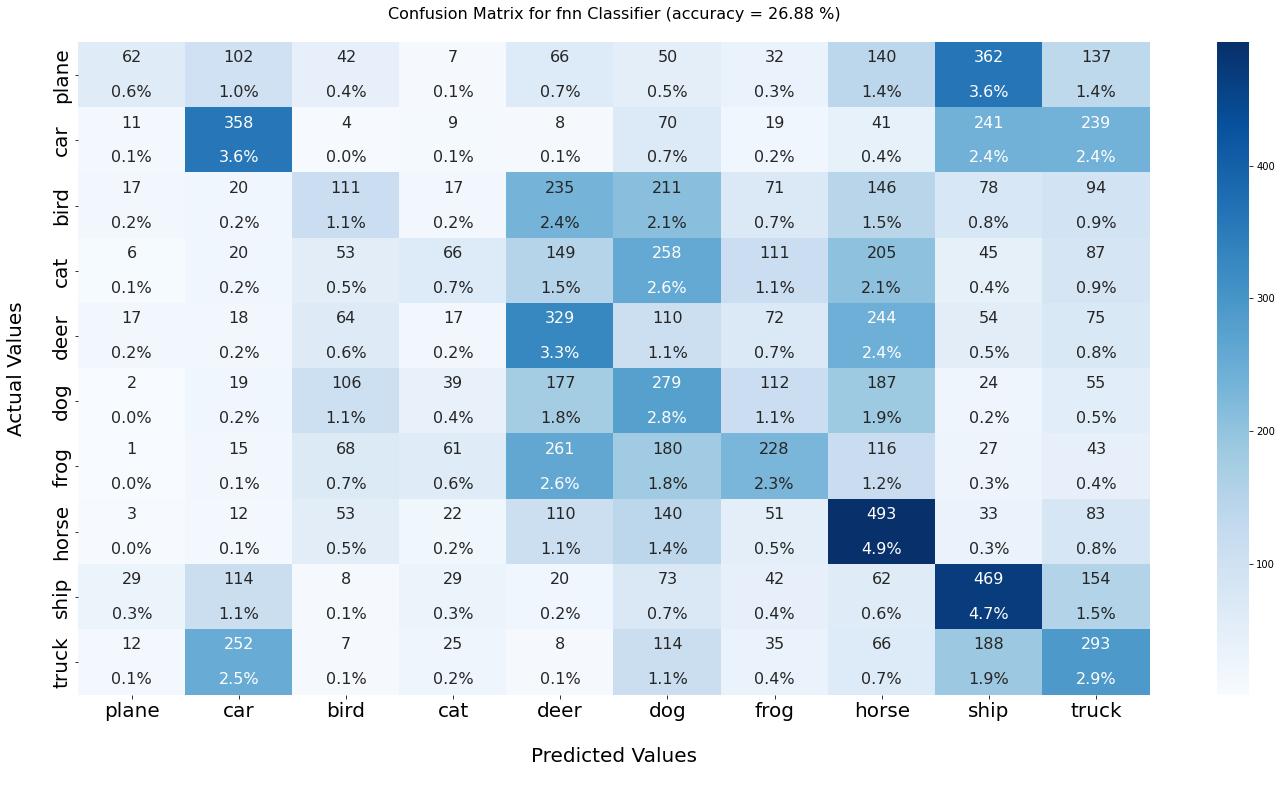

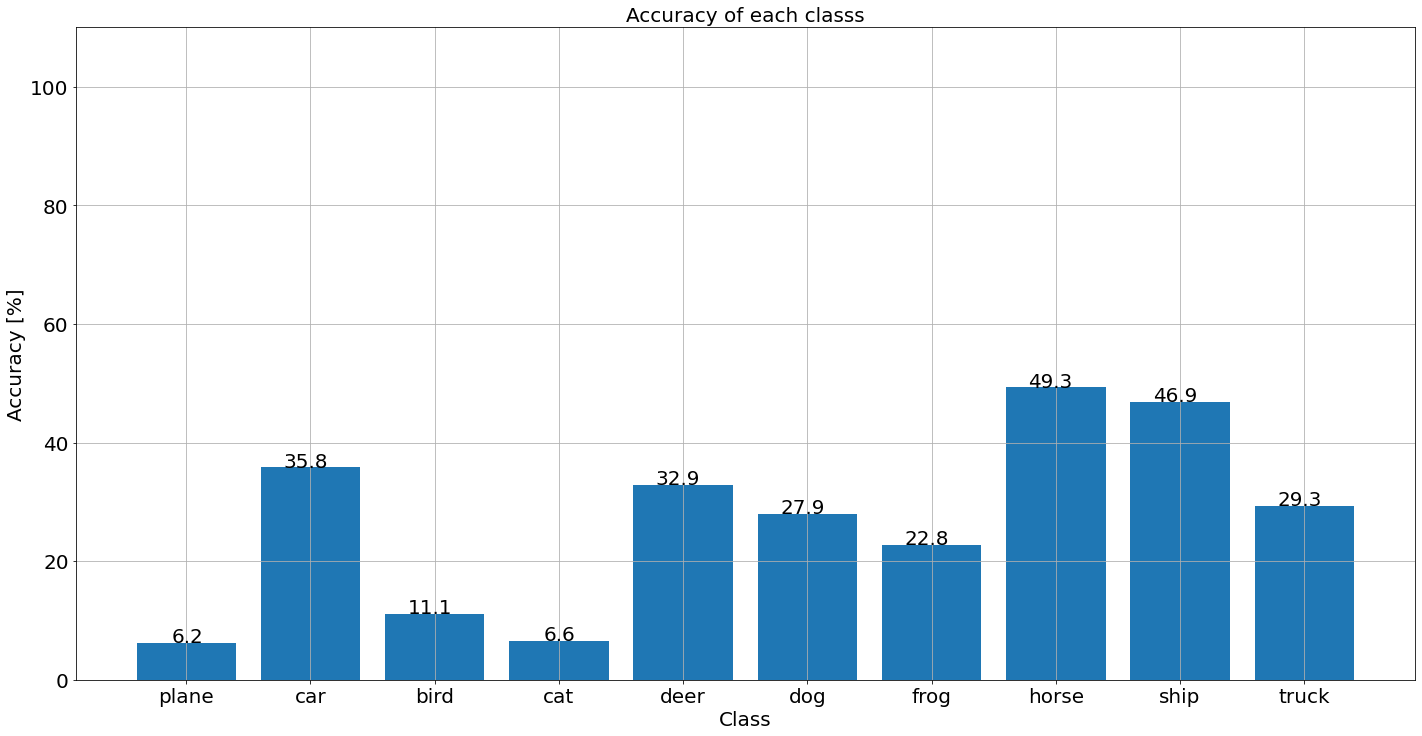


Start train model 7

model 7, Epoch [ 1/10], Step [ 156/1563], Loss: 2.3050
model 7, Epoch [ 1/10], Step [ 312/1563], Loss: 2.3015
model 7, Epoch [ 1/10], Step [ 468/1563], Loss: 2.3055
model 7, Epoch [ 1/10], Step [ 624/1563], Loss: 2.2898
model 7, Epoch [ 1/10], Step [ 780/1563], Loss: 2.2924
model 7, Epoch [ 1/10], Step [ 936/1563], Loss: 2.3143
model 7, Epoch [ 1/10], Step [1092/1563], Loss: 2.2903
model 7, Epoch [ 1/10], Step [1248/1563], Loss: 2.2947
model 7, Epoch [ 1/10], Step [1404/1563], Loss: 2.3161
model 7, Epoch [ 1/10], Step [1560/1563], Loss: 2.2922
model 7, Epoch [ 2/10], Step [ 156/1563], Loss: 2.2950
model 7, Epoch [ 2/10], Step [ 312/1563], Loss: 2.3020
model 7, Epoch [ 2/10], Step [ 468/1563], Loss: 2.3039
model 7, Epoch [ 2/10], Step [ 624/1563], Loss: 2.3023
model 7, Epoch [ 2/10], Step [ 780/1563], Loss: 2.3055
model 7, Epoch [ 2/10], Step [ 936/1563], Loss: 2.3035
model 7, Epoch [ 2/10], Step [1092/1563], Loss: 2.3076
model 7, Epoch [ 2/10], Step [1248/1563], L

test model 7 : 100%|██████████| 313/313 [00:03<00:00, 84.92it/s]



Accuracy of model 7: 10.0 %


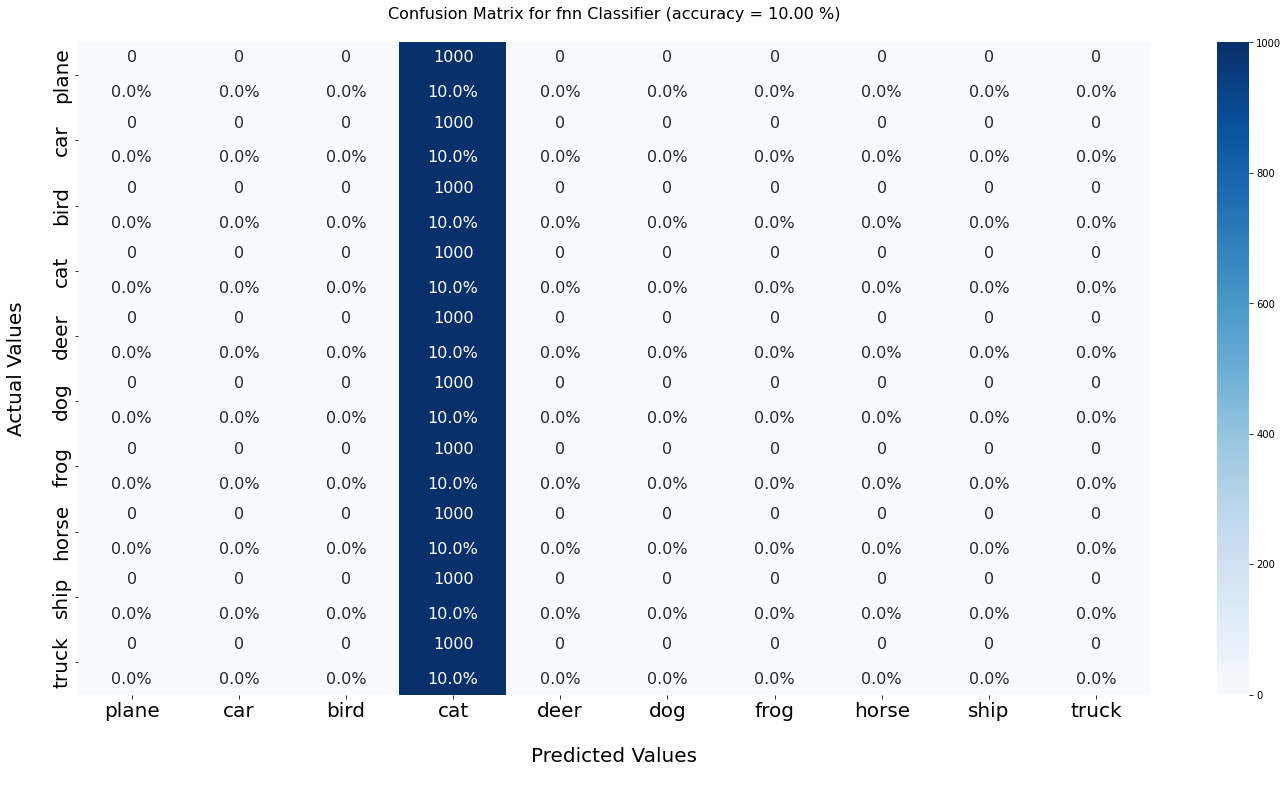

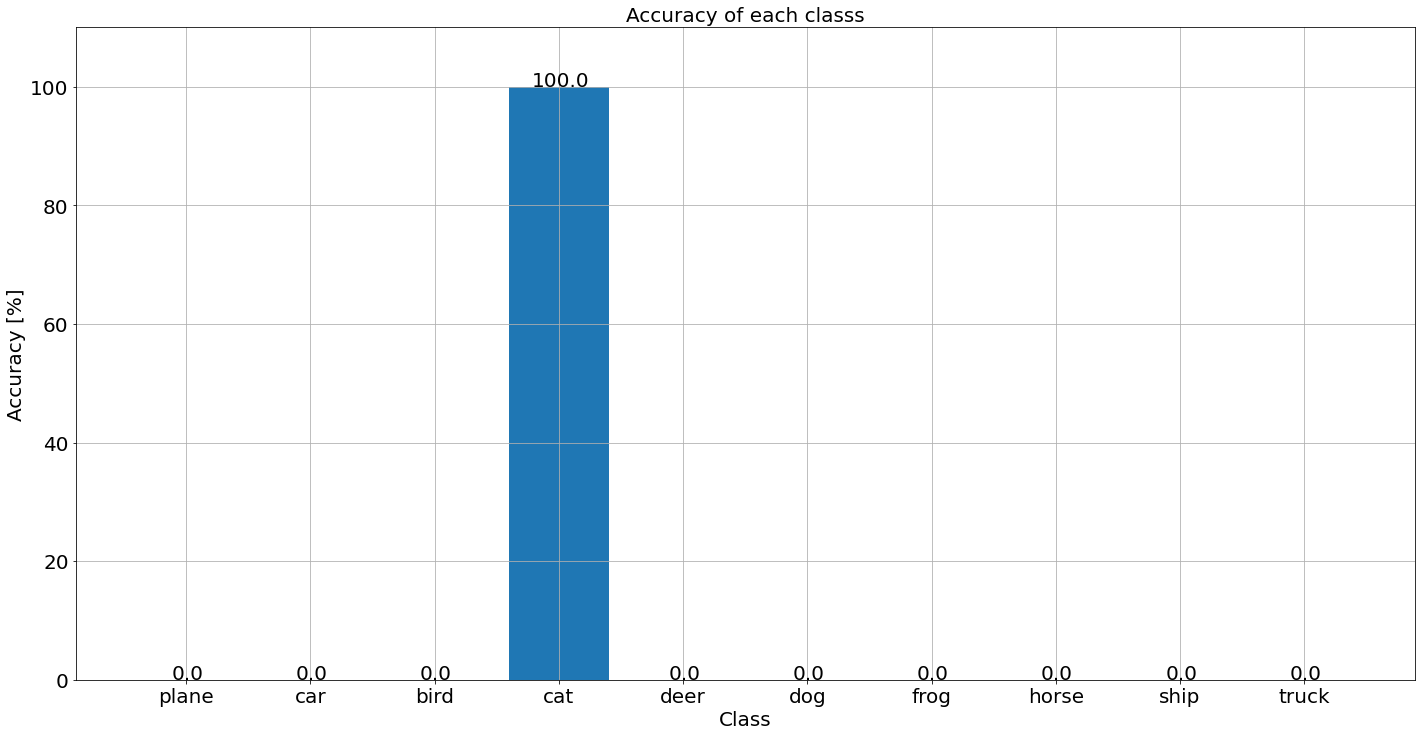


Start train model 8

model 8, Epoch [ 1/10], Step [ 156/1563], Loss: 2.3119
model 8, Epoch [ 1/10], Step [ 312/1563], Loss: 2.3006
model 8, Epoch [ 1/10], Step [ 468/1563], Loss: 2.3026
model 8, Epoch [ 1/10], Step [ 624/1563], Loss: 2.3005
model 8, Epoch [ 1/10], Step [ 780/1563], Loss: 2.3136
model 8, Epoch [ 1/10], Step [ 936/1563], Loss: 2.2945
model 8, Epoch [ 1/10], Step [1092/1563], Loss: 2.3094
model 8, Epoch [ 1/10], Step [1248/1563], Loss: 2.3067
model 8, Epoch [ 1/10], Step [1404/1563], Loss: 2.3092
model 8, Epoch [ 1/10], Step [1560/1563], Loss: 2.2966
model 8, Epoch [ 2/10], Step [ 156/1563], Loss: 2.3104
model 8, Epoch [ 2/10], Step [ 312/1563], Loss: 2.3144
model 8, Epoch [ 2/10], Step [ 468/1563], Loss: 2.3280
model 8, Epoch [ 2/10], Step [ 624/1563], Loss: 2.3233
model 8, Epoch [ 2/10], Step [ 780/1563], Loss: 2.3002
model 8, Epoch [ 2/10], Step [ 936/1563], Loss: 2.3023
model 8, Epoch [ 2/10], Step [1092/1563], Loss: 2.3097
model 8, Epoch [ 2/10], Step [1248/1563], L

test model 8 : 100%|██████████| 313/313 [00:03<00:00, 82.07it/s]



Accuracy of model 8: 10.0 %


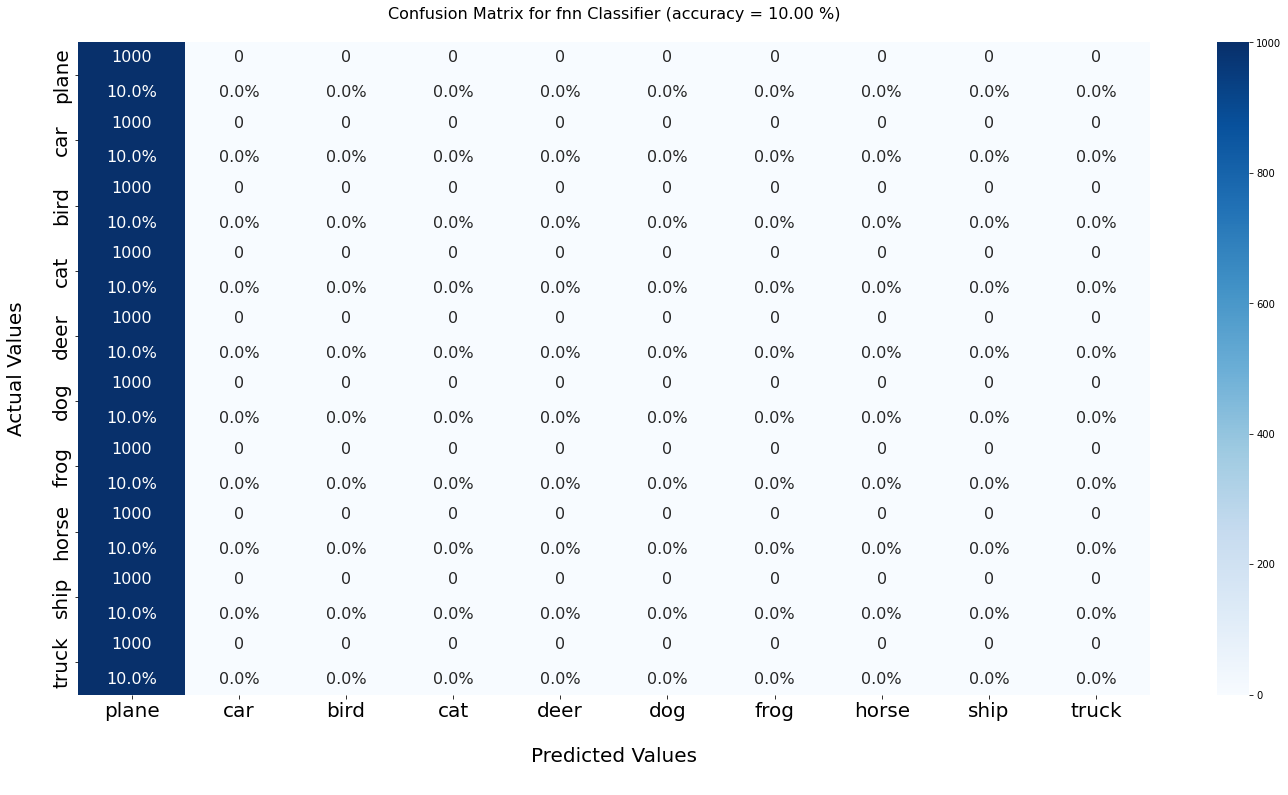

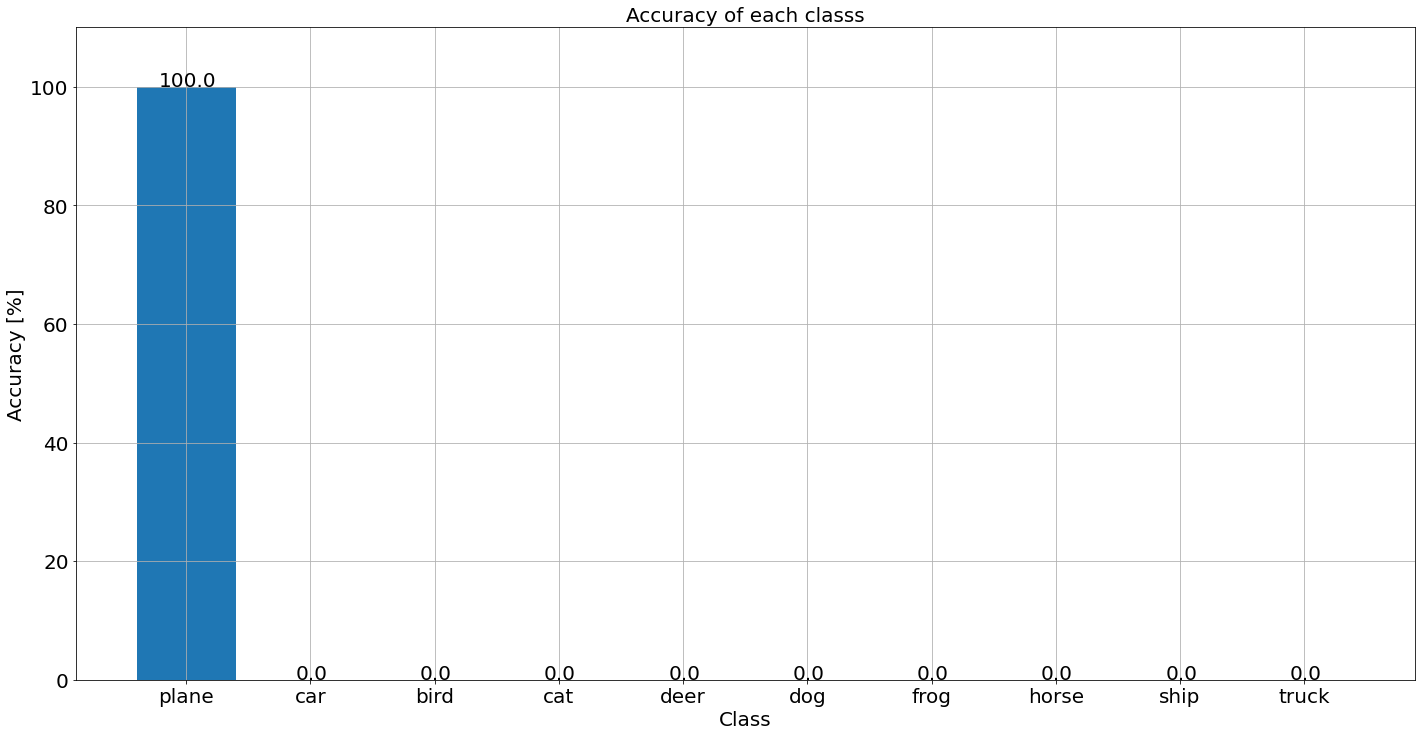


Finished Training models

best model : model 1 with accuracy : 40.83 % 

best model grid : {'convs': [6, 16], 'lins': [120, 84], 'activation': ReLU(inplace=True), 'bias': True, 'lr': 0.01}
best model architecture : 
 MyConvNet(
  (cnn_part): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (linear_part): Sequential(
    (0): Linear(in_features=10816, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
  (criterion): CrossEntropyLoss()
)


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                     std=(0.5, 0.5, 0.5))])

param_grid = {'convs': [[6, 16], [6, 12, 24]],
              'lins': [[120, 84], []],
              'activation': [nn.ReLU(inplace=True)],
              'bias': [True],
              'lr': [0.01, 0.05]}


train_loader, test_loader = load_data(batch_size=32, transform=transform)

in_image, classes = get_dims(train_loader)
best_model = grid_search(param_grid, in_image, classes, train_loader, test_loader, num_epochs=10, device=device)

torch.save(best_model.state_dict(), f'./cnn_model.pt')